<a href="https://colab.research.google.com/github/diefgallegorio/Entrega-MLP-housing/blob/master/HOUSING_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP HOUSING**

Instalo Tensorflow y keras

In [24]:
!pip install tensorflow==2.0.0-alpha0
# !pip install --upgrade tensorflow
# !pip install -U tensorflow-gpu==2.0.0 grpcio
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


### Importo desde Drive base de datos y archivo de funciones para el pre-procesamiento

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras

# para acceder a archivos desde google drive en google colaboratory
# acceso a google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Importo base de datos housing

housing = '1ruQwtMNWfV2zXdntUSPUsjk2fUrskhHM'
downloaded = drive.CreateFile({'id': housing})
downloaded.GetContentFile('housing.csv') 

#Importo archivo de funciones para housing

Funciones = '1TIzuOdjhgFsE3maEH88THxIWGiP8fU5t'
downloaded = drive.CreateFile({'id': Funciones})
downloaded.GetContentFile('Funciones.py') 

#Importo la función declarada en el archivo externo

from Funciones import pre_exploratorio_housing

#Con pandas leo la base de datos y pruebo que cargue adecuadamente
Xdata = pd.read_csv('housing.csv')
Xdata.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Divido el dataset en uno de test y otro de entrenamiento, este ultimo a la vez se divide en uno de validación y otro de entrenamiento

In [0]:
from sklearn.model_selection import train_test_split

XtrainCompleto, Xtest = train_test_split(Xdata, test_size=0.3)
Xtrain, Xvalid = train_test_split(XtrainCompleto, test_size=0.3)
# Xtrain.head()

### Aplico pre-procesamiento all dataset de entrenamiento y validación

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder

#Separo columna de salida, categórigas y numericas
col_sal='median_house_value'
col_num=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms',
        'population','households','median_income']
col_cat=['ocean_proximity']

#Llamo función de pre_exploratorio para completar campos nulos
Xtrain, Ytrain= pre_exploratorio_housing(Xtrain,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')

#Categorizo
codificador = OrdinalEncoder()
Xtrain['ocean_proximity'].value_counts()
Xtrain['ocean_proximity'] = codificador.fit_transform(Xtrain[['ocean_proximity']])

In [0]:
Xvalid, Yvalid= pre_exploratorio_housing(Xvalid,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')

Xvalid['ocean_proximity'].value_counts()
Xvalid['ocean_proximity'] = codificador.fit_transform(Xvalid[['ocean_proximity']])

In [29]:
print("Xtrain", Xtrain.shape)
print("Xvalid", Xvalid.shape)

Xtrain (10113, 9)
Xvalid (4335, 9)


## Creo la red densa y la preparo para entrenarla

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(50, input_shape=(9,), activation="tanh"),
    keras .layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                500       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________


In [39]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
weights

array([[ 1.80219561e-01, -3.44001353e-02, -3.10389370e-01,
        -1.93417087e-01, -8.75025988e-04,  6.20691180e-02,
        -2.86967218e-01, -1.88916102e-01,  1.17955863e-01,
         5.66091835e-02],
       [ 1.47313148e-01, -1.83542073e-02,  1.88746840e-01,
         1.64300472e-01,  2.75153190e-01, -2.77252853e-01,
         2.79408246e-01, -1.82411075e-03,  2.58801550e-01,
         1.81688398e-01],
       [ 1.65478498e-01,  2.02268213e-01, -2.35120952e-02,
         1.20710999e-01, -3.31545472e-02,  6.56704903e-02,
        -2.26920247e-02, -3.00746322e-01,  8.84924829e-02,
         9.30240154e-02],
       [ 5.19680381e-02, -2.04471216e-01, -1.48249865e-01,
        -7.09101111e-02,  2.56902188e-01, -2.42256105e-01,
        -1.91028059e-01, -1.68734491e-01, -1.29737630e-01,
        -2.83487827e-01],
       [ 7.61677325e-02,  1.47961169e-01,  1.92102641e-01,
        -2.07675636e-01, -1.01969495e-01, -2.99955666e-01,
         3.01481336e-01, -1.22693658e-01, -1.23651326e-01,
         1.

In [40]:
print(biases.shape)
biases

(10,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
model.compile(loss=keras.losses.mse,
              optimizer="sgd",
              metrics=[keras.losses.mae])

In [43]:
history = model.fit(Xtrain, Ytrain, epochs=90, validation_data=(Xvalid, Yvalid))

Train on 10113 samples, validate on 4335 samples
Epoch 1/90
10113/10113 [==============================] - 1s 50us/sample - loss: 13456842615.2034 - mean_absolute_error: 91987.3906 - val_loss: 13412212555.2941 - val_mean_absolute_error: 91629.3750
Epoch 2/90
10113/10113 [==============================] - 1s 50us/sample - loss: 13456901021.0731 - mean_absolute_error: 91910.1016 - val_loss: 13416059988.9200 - val_mean_absolute_error: 91825.1562
Epoch 3/90
10113/10113 [==============================] - 0s 49us/sample - loss: 13456599278.5587 - mean_absolute_error: 92039.9219 - val_loss: 13415040120.4706 - val_mean_absolute_error: 91780.7891
Epoch 4/90
10113/10113 [==============================] - 0s 48us/sample - loss: 13456619237.4963 - mean_absolute_error: 92017.1562 - val_loss: 13417933822.5827 - val_mean_absolute_error: 91898.5781
Epoch 5/90
10113/10113 [==============================] - 0s 49us/sample - loss: 13456972580.7432 - mean_absolute_error: 92089.3203 - val_loss: 13416276757

In [44]:
history.params

{'batch_size': 32,
 'do_validation': True,
 'epochs': 90,
 'metrics': ['loss',
  'mean_absolute_error',
  'val_loss',
  'val_mean_absolute_error'],
 'samples': 10113,
 'steps': None,
 'verbose': 0}

In [45]:
history.history

{'loss': [13456842615.203402,
  13456901021.073074,
  13456599278.558687,
  13456619237.496292,
  13456972580.743202,
  13456608301.058836,
  13456618393.435776,
  13456542015.436764,
  13456424932.483734,
  13456642055.746069,
  13456423266.813013,
  13456518924.403837,
  13456578469.63097,
  13456682845.788193,
  13456734717.671116,
  13456717369.361416,
  13456561996.777218,
  13456645598.864037,
  13456638794.245823,
  13456537090.864431,
  13456428491.650747,
  13456503093.41244,
  13456652484.031246,
  13456757810.52665,
  13456758448.691387,
  13456715693.57777,
  13456626399.77534,
  13456561732.955206,
  13456820269.66637,
  13456496404.377731,
  13456723233.085335,
  13456649940.687828,
  13456836945.612183,
  13456593140.0265,
  13456552616.531698,
  13456450590.93365,
  13456662011.89914,
  13456579434.242659,
  13456457220.60714,
  13456506252.619005,
  13456695275.748838,
  13456752518.898052,
  13456735041.588451,
  13456568732.125383,
  13456597896.847227,
  13456634929

In [46]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

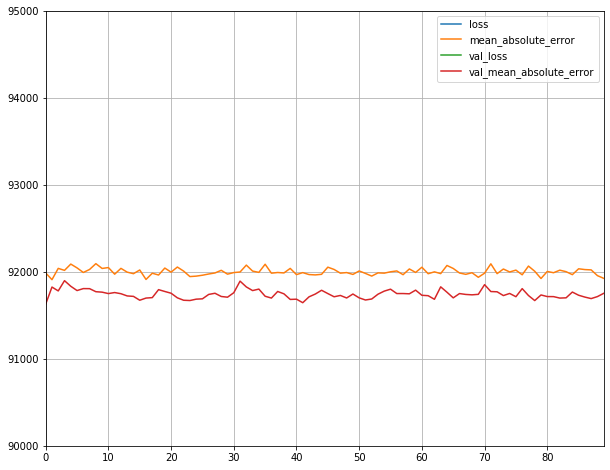

In [51]:
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(90000, 95000)
#save_fig("keras_learning_curves_plot")
plt.show()

## Evaluo con el conjunto de datos de prueba

In [0]:
Xtest, Ytest = pre_exploratorio_housing(Xtest,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')

#Categorizo
codificador = OrdinalEncoder()
Xtest['ocean_proximity'].value_counts()
Xtest['ocean_proximity'] = codificador.fit_transform(Xtest[['ocean_proximity']])

In [0]:
X_test = Xtest
y_test = Ytest

In [54]:
model.evaluate(Xtest, Ytest)

6192/6192 [==============================] - 0s 24us/sample - loss: 13030397666.2326 - mean_absolute_error: 90108.5234


[13030397666.232557, 90108.52]

In [55]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[207914.77],
       [207914.77],
       [207914.77]], dtype=float32)

In [56]:
y_pred = model.predict_classes(X_new)
y_pred

array([[1],
       [1],
       [1]], dtype=int32)

In [57]:
y_new = y_test[:3]
y_new

2147      67300.0
4862     175000.0
12982    119800.0
Name: median_house_value, dtype: float64

In [0]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()